# MONAI : Tutorial : modules
## 3d_image_transforms

参照URL:
- https://github.com/Project-MONAI/tutorials/blob/main/modules/3d_image_transforms.ipynb

## 0. 準備

In [1]:
# パッケージのインストール
#!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
#!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
# パッケージのインポート
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from monai.apps import download_and_extract
from monai.config import print_config
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
)

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/akira/venv/monai/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.26.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installi

In [3]:
# データフォルダ
root_dir = './data/MSD'

In [4]:
# データダウンロード
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, 'Task09_Spleen.tar')
data_dir = os.path.join(root_dir, 'Task09_Spleen')
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## 1. データセット

In [5]:
train_images = sorted(glob(os.path.join(data_dir, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'labelsTr', '*.nii.gz')))

data_dicts = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]

In [6]:
train_data_dicts[0]

{'image': './data/MSD/Task09_Spleen/imagesTr/spleen_10.nii.gz',
 'label': './data/MSD/Task09_Spleen/labelsTr/spleen_10.nii.gz'}

### 1.1 NlfTlファルのロード

In [7]:
loader = LoadImage(dtype=np.float32, image_only=True)

In [8]:
image = loader(train_data_dicts[0]['image'])

print(f"image shape: {image.shape}")
print(f"image affine:\n{image.meta['affine']}")
print(f"image pixdim:\n{image.pixdim}")

image shape: torch.Size([512, 512, 55])
image affine:
tensor([[   0.9766,    0.0000,    0.0000, -499.0232],
        [   0.0000,    0.9766,    0.0000, -499.0232],
        [   0.0000,    0.0000,    5.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
image pixdim:
tensor([0.9766, 0.9766, 5.0000], dtype=torch.float64)


In [9]:
loader = LoadImaged(keys=['image', 'label'], image_only=False)

In [10]:
data_dict = loader(train_data_dicts[0])

print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image pixdim:\n{data_dict['image'].pixdim}")

image shape: torch.Size([512, 512, 55])
label shape: torch.Size([512, 512, 55])
image pixdim:
tensor([0.9766, 0.9766, 5.0000], dtype=torch.float64)


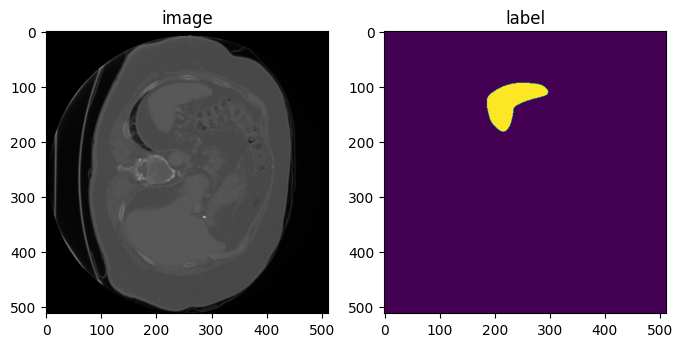

In [11]:
image, label = data_dict['image'], data_dict['label']
plt.figure('visualize', figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 30], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 30])
plt.show()

### 1.2 1次元の確認

In [12]:
ensure_channel_first = EnsureChannelFirstd(keys=['image', 'label'])
datac_dict = ensure_channel_first(data_dict)
print(f"image shaep: {datac_dict['image'].shape}")

image shaep: torch.Size([1, 512, 512, 55])


### 1.3 軸コードの方向転換

In [13]:
orientation = Orientationd(keys=['image', 'label'], axcodes='PLI')

In [14]:
data_dict = orientation(datac_dict)

print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after spacing:\n{data_dict['image'].meta['affine']}")
print(f"label affine after spacing:\n{data_dict['label'].meta['affine']}")

image shape: torch.Size([1, 512, 512, 55])
label shape: torch.Size([1, 512, 512, 55])
image affine after spacing:
tensor([[ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.7684e-07],
        [-9.7656e-01,  0.0000e+00,  0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00, -5.0000e+00,  2.7000e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
label affine after spacing:
tensor([[ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.7684e-07],
        [-9.7656e-01,  0.0000e+00,  0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00, -5.0000e+00,  2.7000e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


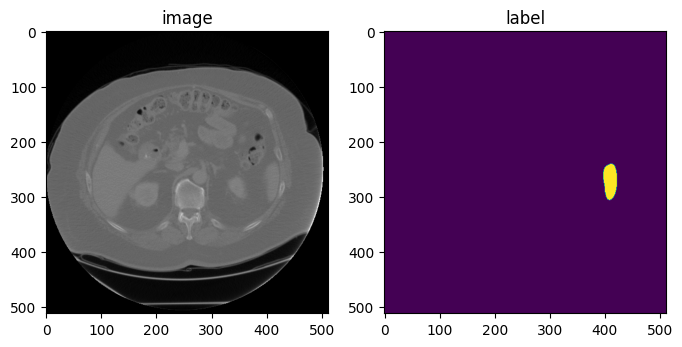

In [15]:
image, label = data_dict['image'], data_dict['label']
plt.figure('visualize', figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[0, :, :, 30], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[0, :, :, 30])
plt.show()

### 1.4 ボクセルサイズへのリサンプリング

In [16]:
spacing = Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 5.0), mode=('bilinear', 'nearest'))

In [17]:
data_dict = spacing(data_dict)

print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after Spacing:\n{data_dict['image'].meta['affine']}")
print(f"label affine after Spacing:\n{data_dict['label'].meta['affine']}")

image shape: torch.Size([1, 334, 334, 55])
label shape: torch.Size([1, 334, 334, 55])
image affine after Spacing:
tensor([[ 0.0000e+00, -1.5000e+00,  0.0000e+00,  4.7684e-07],
        [-1.5000e+00,  0.0000e+00,  0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00, -5.0000e+00,  2.7000e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
label affine after Spacing:
tensor([[ 0.0000e+00, -1.5000e+00,  0.0000e+00,  4.7684e-07],
        [-1.5000e+00,  0.0000e+00,  0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00, -5.0000e+00,  2.7000e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)


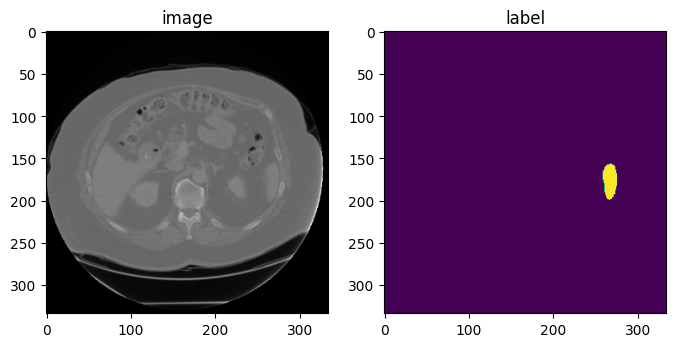

In [18]:
image, label = data_dict['image'], data_dict['label']

plt.figure('visualize', figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[0, :, :, 30], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[0, :, :, 30])
plt.show()

### 1.5 ランダムなアフィン変換

In [19]:
rand_affine = RandAffined(
    keys=['image', 'label'],
    mode=('bilinear', 'nearest'),
    prob=1.0,
    spatial_size=(300, 300, 50),
    translate_range=(40, 40, 2),
    rotate_range=(np.pi / 36, np.pi / 36, np.pi / 4),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode='border',
)

rand_affine.set_random_state(seed=123)

In [20]:
affined_data_dict = rand_affine(data_dict)
print(f"image shape: {affined_data_dict['image'].shape}")


image shape: torch.Size([1, 300, 300, 50])


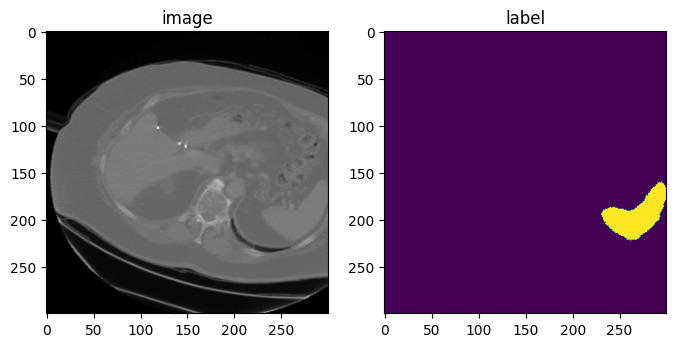

In [21]:
image, label = affined_data_dict['image'][0], affined_data_dict['label'][0]

plt.figure('visualize', figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 23], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 23])
plt.show()

### 1.6 ランダムな弾性変形

In [22]:
rand_elastic = Rand3DElasticd(
    keys=['image', 'label'],
    mode=('bilinear', 'nearest'),
    prob=1.0,
    sigma_range=(5, 8),
    magnitude_range=(100, 200),
    spatial_size=(300, 300, 10),
    translate_range=(50, 50, 2),
    rotate_range=(np.pi / 36, np.pi / 36, np.pi),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode='border',
)

rand_elastic.set_random_state(seed=123)

In [23]:
deformed_data_dict = rand_elastic(data_dict)
print(f"image shape: {deformed_data_dict['image'].shape}")

image shape: torch.Size([1, 300, 300, 10])


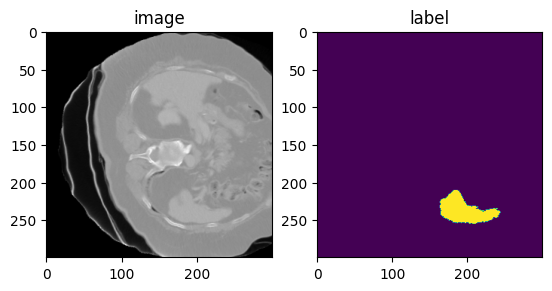

In [24]:
image, label = deformed_data_dict['image'][0], deformed_data_dict['label'][0]

plt.figure('visualize')
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 5], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 5])
plt.show()
